<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/kalman/Kalman_Filters_for_Nifty_ema.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
!pip install pykalman
!pip install yfinance
!pip install pandas-ta==0.2.45b
!pip install ffn

In [80]:
#Importing dependencies#
from pykalman import KalmanFilter
import numpy as np
import pylab as pl
import pandas as pd
import yfinance as yf
from scipy import poly1d
from datetime import datetime
import pandas_ta as ta
import matplotlib.pyplot as plt
import ffn
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

[*********************100%***********************]  1 of 1 completed


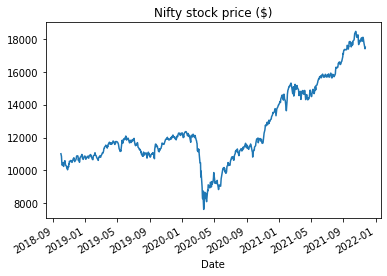

In [81]:
nifty_df = yf.download('^nsei',start='2018-10-01') # 2018
nifty_df['Adj Close'].plot(title='Nifty stock price ($)');


In [82]:
#nifty_df = yf.download('sbin.ns',start='2014-01-01',progress=False)


In [83]:
df = nifty_df[['Adj Close']]


mean 16071.545124238208


Text(0.5, 0, 'Days')

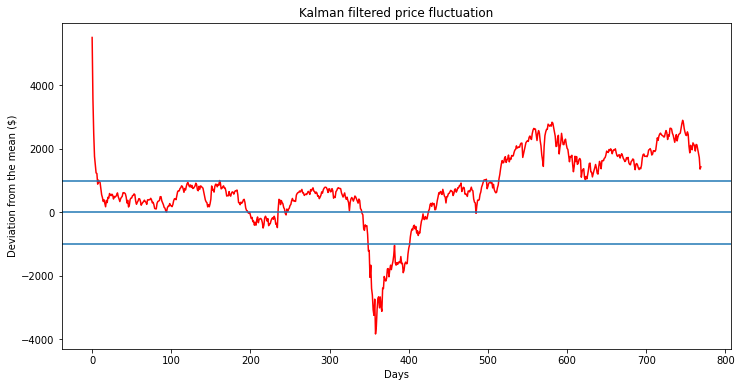

In [84]:
f = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance = 1,
                  transition_covariance = 0.0001)
mean, cov = f.filter(df['Adj Close'].values)
mean, std = mean.squeeze(), np.std(cov.squeeze())
print(f'mean {mean[-1]}')

plt.figure(figsize=(12,6))
plt.plot(df['Adj Close'].values - mean, 'red', lw=1.5)

plt.axhline(y=0)
plt.axhline(y=1000)
plt.axhline(y=-1000)
plt.title("Kalman filtered price fluctuation")
plt.ylabel("Deviation from the mean ($)")
plt.xlabel("Days")

In [85]:
nifty =pd.DataFrame({'Date': nifty_df.index,'Close':df['Adj Close'].values - mean})


In [86]:
nifty['30 Day MA'] = nifty['Close'].rolling(window=20).mean()
# set .std(ddof=0) for population std instead of sample
nifty['30 Day STD'] = nifty['Close'].rolling(window=20).std() 
nifty['Upper Band'] = nifty['30 Day MA'] + (nifty['30 Day STD'] *0.5)
nifty['Lower Band'] = nifty['30 Day MA'] - (nifty['30 Day STD'] *0.5)

nifty.ta.macd(fast=26,slow=50,signal=18, append=True)

print()

In [87]:
nifty=nifty.set_index('date')

In [88]:
nifty.tail(2)

,close,30 Day MA,30 Day STD,Upper Band,Lower Band,MACD_26_50_18,MACDh_26_50_18,MACDs_26_50_18
date,,,,,,,,
2021-11-22,1359.395477,2098.750469,286.765672,2242.133305,1955.367633,-64.648446,-95.020723,30.372277
2021-11-23,1431.804485,2044.465822,305.475292,2197.203467,1891.728176,-85.611288,-103.774768,18.163481


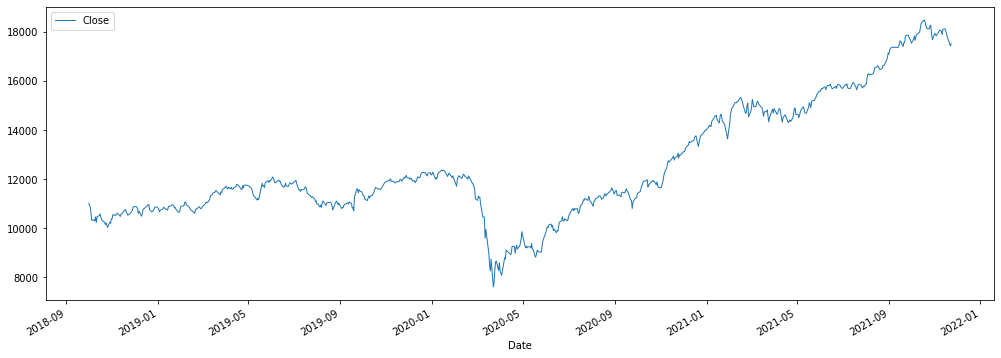

In [89]:
nifty_df[['Close']][-1000:].plot(figsize=(17,6),linewidth=1);

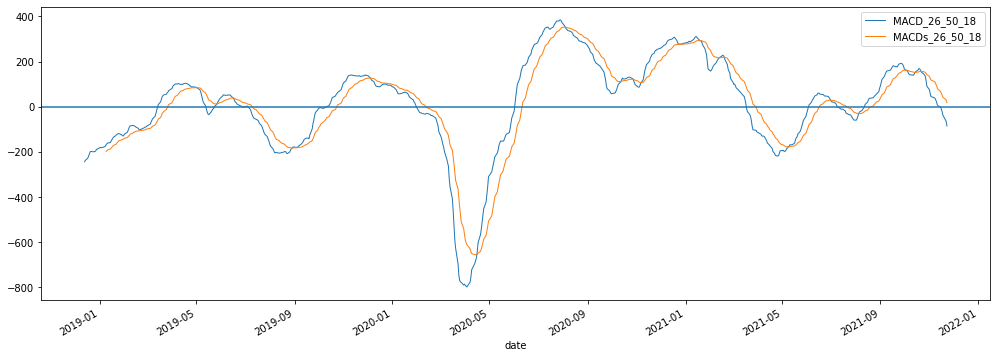

In [90]:
nifty[['MACD_26_50_18','MACDs_26_50_18']][-1000:].plot(figsize=(17,6),linewidth=1);
plt.axhline(y=0);

In [91]:
nifty['slope']=abs(nifty['MACD_26_50_18'].diff(5))
nifty['slope_s']=abs(nifty['MACDs_26_50_18'].diff(5))

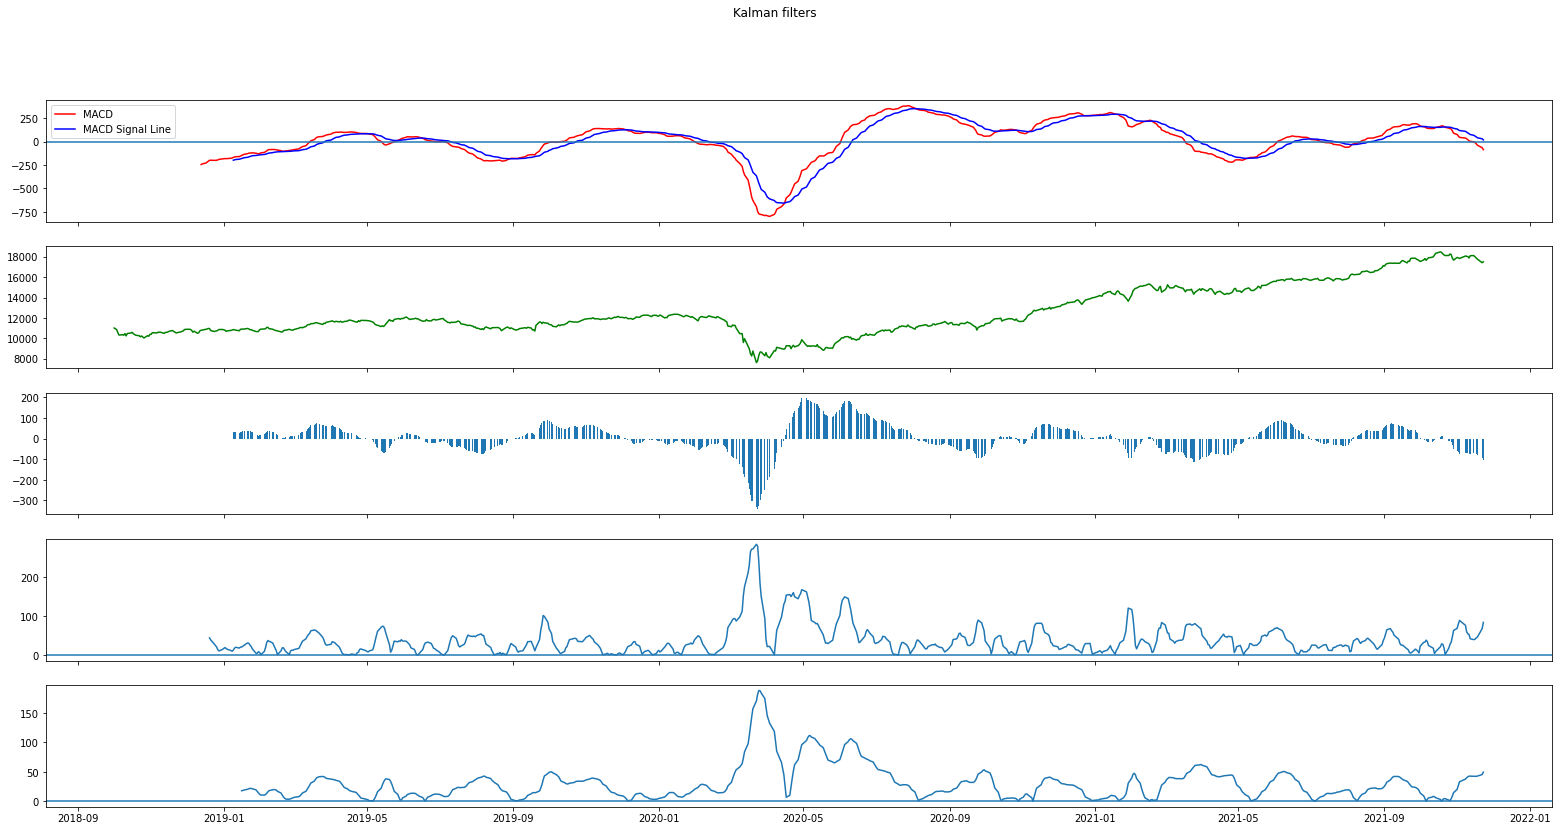

In [92]:
fig, ax = plt.subplots(5,1,figsize=(27,13),linewidth=1,sharex=True)
ax[0].plot(nifty.loc[:, :].index[-1000:], nifty.loc[:, 'MACD_26_50_18'][-1000:],'r', label='MACD')
ax[0].plot(nifty.loc[:, :].index[-1000:], nifty.loc[:, 'MACDs_26_50_18'][-1000:],'b', label='MACD Signal Line')
ax[2].bar(nifty.loc[:, :].index[-1000:], nifty.loc[:, 'MACDh_26_50_18'][-1000:], label='MACD Signal Line')
ax[1].plot(nifty_df.loc[:, :].index[-1000:], nifty_df.loc[:, 'Close'][-1000:],'g', label='NH moving avg 50 days')
ax[3].plot(nifty.iloc[:, :].index[-1000:], nifty.loc[:, 'slope'][-1000:], label='Slope')
ax[4].plot(nifty.iloc[:, :].index[-1000:], nifty.loc[:, 'slope_s'][-1000:], label='Slope')
plt.suptitle('Kalman filters')
ax[0].axhline(y=0)
ax[3].axhline(y=0)
ax[4].axhline(y=0)
ax[0].legend(loc='upper left')
plt.show()


In [93]:
nifty.tail(1)

,close,30 Day MA,30 Day STD,Upper Band,Lower Band,MACD_26_50_18,MACDh_26_50_18,MACDs_26_50_18,slope,slope_s
date,,,,,,,,,,
2021-11-23,1431.804485,2044.465822,305.475292,2197.203467,1891.728176,-85.611288,-103.774768,18.163481,84.224673,49.552118


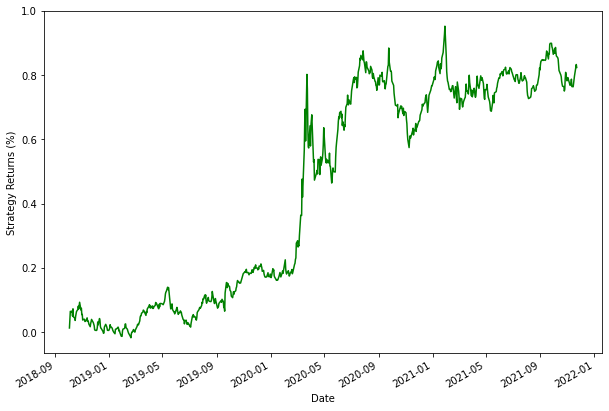

sharpe ratio :  0.08474108532719551
sortino ratio :  5.195090337144085


In [94]:
nifty['signals']=np.where(nifty['MACDh_26_50_18']>0,1,-1)
# Calculate daily returns
nifty['Return'] = nifty_df.Close.pct_change()
 
# Calculate strategy returns
nifty['Strategy_F'] = nifty.Return * nifty.signals.shift(1)

# Calculate geometric returns
geometric_returns = ((nifty.Strategy_F+1).cumprod()-1)
#np.sum(np.log(data/data.shift())*portfolio, axis=1)
# Plot geometric returns
geometric_returns.plot(figsize=(10, 7),color='g')
volatility = geometric_returns.std() * np.sqrt(252)
sharpe_ratio = (geometric_returns.mean() - 0.05/252) / volatility 
plt.ylabel("Strategy Returns (%)")
plt.xlabel("Date")
plt.show()
print('sharpe ratio : ' ,sharpe_ratio)
std_neg = geometric_returns[geometric_returns<0].std()*np.sqrt(252)
sortino_ratio=(geometric_returns.mean() - 0.05/252)/std_neg
print('sortino ratio : ' , sortino_ratio) 

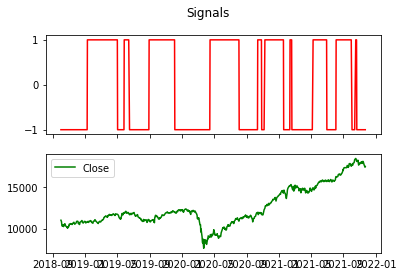

In [95]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'signals'],'r', label='Signals')
ax[1].plot(df.loc[:, :].index, df.loc[:, 'Adj Close'],'g', label='Close')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('Signals')
ax[1].legend()
plt.show()


In [96]:
stats = geometric_returns.calc_stats()  # use .calc_stats() on a series to invoke ffn.
stats.display()

Stats for Strategy_F from 2018-10-01 00:00:00 - 2021-11-23 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR     Max Drawdown
--------------  --------  -------  --------------
-                   0.53  269.20%  -117.84%

Annualized Returns:
mtd    3m     6m      ytd    1y      3y       5y    10y    incep.
-----  -----  ------  -----  ------  -------  ----  -----  --------
1.89%  9.19%  10.62%  7.45%  30.07%  201.62%  -     -      269.20%

Periodic:
        daily      monthly    yearly
------  ---------  ---------  --------
sharpe  0.53       0.58       0.68
mean    1098.19%   3264.02%   1067.63%
vol     2077.81%   5603.06%   1570.99%
skew    15.28      6.07       1.65
kurt    350.94     36.93      -
best    2938.73%   9840.75%   2872.49%
worst   -1141.25%  -88.09%    7.45%

Drawdowns:
max       avg        # days
--------  -------  --------
-117.84%  -22.94%     44.92

Misc:
---------------  -------
avg. up month    474.05%
avg. down month  -24.33%

In [97]:
stats.stats

start                    2018-10-01 00:00:00
end                      2021-11-23 00:00:00
rf                                         0
total_return                             NaN
cagr                                 2.69201
max_drawdown                        -1.17843
calmar                               2.28441
mtd                                 0.018853
three_month                        0.0919213
six_month                           0.106221
ytd                                0.0745128
one_year                            0.300716
three_year                           2.01625
five_year                                NaN
ten_year                                 NaN
incep                                2.69201
daily_sharpe                        0.528531
daily_sortino                        1.39906
daily_mean                           10.9819
daily_vol                            20.7781
daily_skew                           15.2823
daily_kurt                           350.937
best_day  

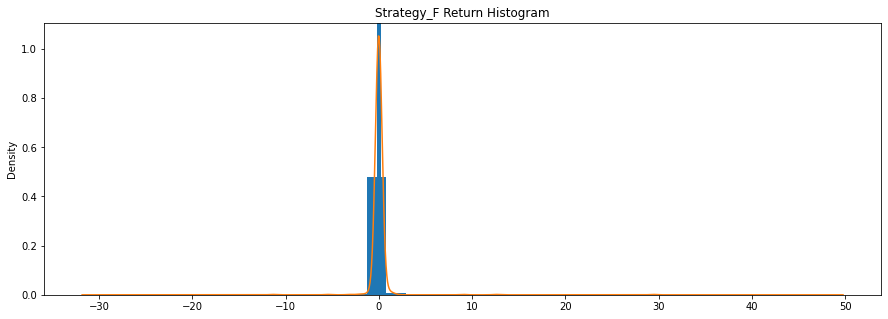

In [98]:
stats.plot_histogram()

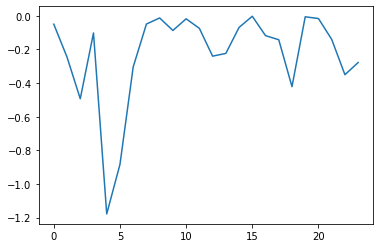

In [99]:
stats.drawdown_details['drawdown'].plot();

In [100]:
stats.display_monthly_returns()

  Year     Jan     Feb      Mar    Apr     May     Jun     Jul    Aug    Sep     Oct     Nov    Dec      YTD
------  ------  ------  -------  -----  ------  ------  ------  -----  -----  ------  ------  -----  -------
  2018    0       0        0      0       0       0       0      0      0     305.15  -88.09  -7.24   -55.25
  2019  -29.53  -82.95  9840.75  22.68  -29.52  -52.41  202.53   7.72  46      28.14    9.73  -9.58  2872.49
  2020   10.39   38.54   109.04   9.81   -7.29   20.3    18.04  -5.47   2.13  -15.08   -7.01  20.03   322.95
  2021   24.18  -18.23    -3.22   0.22    4.84    2.01   -1.91   3.79   6.29   -7.46    1.89   0        7.45
